<a href="https://colab.research.google.com/github/swlee23/Deep-Learning-Time-Series-Anomaly-Detection/blob/5-24_sCurr/DeepAnT_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Things to be included
# 1. visualization tools for optimization
# 2. visualization tools for plotting actual and predicted sequence, and anomaly points
# 3. Computation cost calculation
# 4. Data of approximately 50~60 days required

In [2]:
import numpy as np
from numpy import array
import random
from random import randint
import os
import matplotlib.pyplot as plt
import matplotlib.dates
from  matplotlib.dates import date2num
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [0]:
                       """Anomaly detector"""
def anomaly_detector(prediction_seq, ground_truth_seq):
    # calculate Euclidean between actual seq and predicted seq
    dist = np.linalg.norm(ground_truth_seq - prediction_seq)  
    if (dist > anm_det_thr):
        return true  # anomaly
    else:
        return false # normal 

In [0]:
              """Hyperparameters"""
w = 40                   # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 6                  # Prediction window (number of time stampes required to be 
                         # predicted)
n_features = 1           # Univariate time series

kernel_size = 2          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

epochs = 500
dropout_rate = 0.5       # Dropout rate in the fully connected layer
learning_rate = 2e-5  
anm_det_thr = 0.8        # Threshold for classifying anomaly (0.5~0.8)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


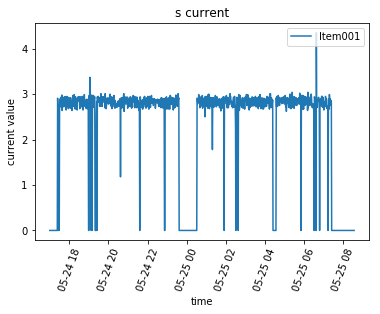

<Figure size 7200x720 with 0 Axes>

In [6]:
               """Data loading (S current)"""
df_Scurr = pd.read_csv('https://raw.githubusercontent.com/swlee23/Deep-Learning-Time-Series-Anomaly-Detection/master/data/HisItemCurrSMinute.csv')
df_Scurr = df_Scurr.fillna(0)
df_Scurr["DataSavedTime"] = pd.to_datetime(df_Scurr["DataSavedTime"])
df_Scurr["DataSavedTime"] = matplotlib.dates.date2num(df_Scurr["DataSavedTime"])
plt.xticks(rotation=70)
plt.plot_date(x=df_Scurr["DataSavedTime"], y=df_Scurr['Item001'], 
              linestyle='solid', marker='None')
plt.title('s current')
plt.ylabel('current value')
plt.xlabel('time')
plt.legend(['Item001'], loc='upper right')
plt.figure(figsize=(100,10))
plt.show()

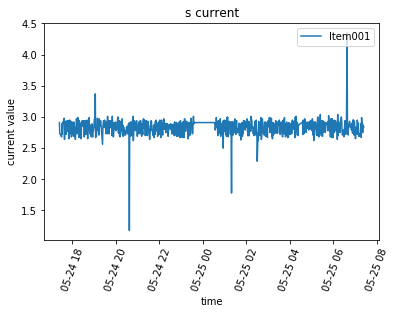

<Figure size 7200x720 with 0 Axes>

In [7]:
              """Data preprocessing"""
# split a univariate sequence into samples
def split_sequence(sequence):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + w
		out_end_ix = end_ix + p_w
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# remove zero values
df_Scurr = df_Scurr[df_Scurr['Item001'] != 0]
plt.xticks(rotation=70)
plt.plot_date(x=df_Scurr["DataSavedTime"], y=df_Scurr['Item001'], 
              linestyle='solid', marker='None')
plt.title('s current')
plt.ylabel('current value')
plt.xlabel('time')
plt.legend(['Item001'], loc='upper right')
plt.figure(figsize=(100,10))
plt.show()

# define input sequence
raw_seq = list(df_Scurr['Item001'])

# split into samples
batch_sample, batch_label = split_sequence(raw_seq)

# summarize the data
# for i in range(5):
# 	print(X[i], Y[i])
  
# 2. reshape from [samples, timesteps] into [samples, timesteps, features]

# need to convert batch into 3D tensor of the form [batch_size, input_seq_len, n_features]
batch_sample = batch_sample.reshape((batch_sample.shape[0], batch_sample.shape[1], n_features))

In [8]:
              """Generate model for predictor"""
model = Sequential()

# Convolutional Layer #1
# Computes 32 features using a 1D filter(kernel) of with w with ReLU activation. 
# Padding is added to preserve width.
# Input Tensor Shape: [batch_size, w, 1] / batch_size = len(batch_sample)
# Output Tensor Shape: [batch_size, w, num_filt_1] (num_filt_1 = 32 feature vectors)
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))

# Pooling Layer #1
# First max pooling layer with a filter of length 2 and stride of 2
# Input Tensor Shape: [batch_size, w, num_filt_1]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1]

model.add(MaxPooling1D(pool_size=pool_size_1)) 
                    #  strides=pool_strides_1, 
                    #  padding='valid'))

# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 0.5 * w, 32]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

# Max Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
model.add(MaxPooling1D(pool_size=pool_size_2))
                    #  strides=pool_strides_2, 
                    #  padding='valid'
          
# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
model.add(Flatten())

# Dense Layer (Output layer)
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 1024]
model.add(Dense(units=num_nrn_dl, activation='relu'))  

# Dropout
# Prevents overfitting in deep neural networks
model.add(Dropout(dropout_rate))

# Output layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, p_w]
model.add(Dense(units=num_nrn_ol))

# Summarize model structure
model.summary()

W0704 08:50:15.200042 140518448625536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 08:50:15.245979 140518448625536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 08:50:15.253892 140518448625536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 08:50:15.309787 140518448625536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0704 08:50:15.369998 140518448625536 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 39, 32)            96        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 32)            2080      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                11560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
__________

In [9]:
                 '''configure model'''
model.compile(optimizer='adam', 
              loss='mean_absolute_error')

# sgd = keras.optimizers.SGD(lr=learning_rate, 
#                          decay=1e-6, 
#                          momentum=0.9, 
#                          nesterov=True)
# model.compile(optimizer='sgd', 
#               loss='mean_absolute_error', 
#               metrics=['accuracy'])

W0704 08:50:15.432543 140518448625536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [10]:
                    '''Training'''
model_fit = model.fit(batch_sample,
                      batch_label,
                      epochs=epochs,
                      verbose=1)

W0704 08:50:15.832987 140518448625536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/500
710/710 [==============================] - 1s 1ms/step - loss: 2.0104
Epoch 2/500
710/710 [==============================] - 0s 108us/step - loss: 1.1009
Epoch 3/500
710/710 [==============================] - 0s 117us/step - loss: 0.9597
Epoch 4/500
710/710 [==============================] - 0s 119us/step - loss: 0.8924
Epoch 5/500
710/710 [==============================] - 0s 131us/step - loss: 0.8673
Epoch 6/500
710/710 [==============================] - 0s 120us/step - loss: 0.8255
Epoch 7/500
710/710 [==============================] - 0s 117us/step - loss: 0.8075
Epoch 8/500
710/710 [==============================] - 0s 119us/step - loss: 0.7460
Epoch 9/500
710/710 [==============================] - 0s 121us/step - loss: 0.7588
Epoch 10/500
710/710 [==============================] - 0s 112us/step - loss: 0.7180
Epoch 11/500
710/710 [==============================] - 0s 117us/step - loss: 0.7103
Epoch 12/500
710/710 [==============================] - 0s 118us/step - loss

In [11]:
                 """Testing with random interval(DeepAnT)"""
# Set number of test sequences 
n_test_seq = 1

# Split a univariate sequence into samples
def generate_test_batch(raw_seq, n_test_seq):
  # Sample a portion of the raw_seq randomly
    ran_ix = random.randint(0,len(raw_seq) - n_test_seq * w - n_test_seq * p_w)
    raw_test_seq = array(raw_seq[ran_ix:ran_ix + n_test_seq * w +  n_test_seq * p_w])
    batch_test_seq, batch_test_label = list(), list()
    ix = ran_ix
    for i in range(n_test_seq):
        # gather input and output parts of the pattern
        seq_x = raw_seq[ix : ix+w],
        seq_y = raw_seq[ix+w : ix+w+p_w]
        ix = ix+w+p_w
        batch_test_seq.append(seq_x)
        batch_test_label.append(seq_y)
    return array(batch_test_seq), array(batch_test_label)

raw_seq = list(df_Scurr['Item001'])
batch_test_seq, batch_test_label = generate_test_batch(raw_seq, n_test_seq)
batch_test_seq = batch_test_seq.reshape((batch_test_seq.shape[0], w, n_features))
batch_test_label = batch_test_label.reshape((batch_test_label.shape[0], p_w))

# Returns the loss value & metrics values for the model in test mode
model.evaluate(x=batch_test_seq,
               y=batch_test_label,
               verbose=1) 

1/1 [==============================] - 0s 48ms/step


0.08682743459939957

In [0]:
               """Save Weights (DeepAnT)"""
# save it to disk so we can load it back up anytime
model.save_weights('05-24-sCurr_DeepAnT.h5')  

In [13]:
            """Predicting random intervals (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.save_weights('05-24-sCurr_DeepAnT.h5')  
          
# Sample a portion of the raw_seq randomly
# 1. Choose 
raw_seq = list(df_Scurr['Item001'])
ran_ix = random.randint(1,len(raw_seq) - w - p_w)
input_seq = array(raw_seq[ran_ix : ran_ix + w])
target_seq = array(raw_seq[ran_ix + w : ran_ix + w + p_w])
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
yhat = model.predict(input_seq, verbose=1)

# Print our model's predictions.
print(yhat)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]

1/1 [==============================] - 0s 52ms/step
[[ 0.46644378  0.00073365 -0.3285263   0.5135169   0.22978374 -0.30211395]]
[2.81 2.97 2.8  2.84 2.89 2.8 ]


In [14]:
            """Predicting future sequence (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.save_weights('05-24-sCurr_DeepAnT.h5')  
          
    
raw_seq = list(df_Scurr['Item001'])
endix = len(raw_seq) - w - p_w
input_seq = array(raw_seq[endix:endix+w])
target_seq = array(raw_seq[endix+w:endix+w+p_w]) 
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
predicted_seq = model.predict(input_seq, verbose=1)

# Print our model's predictions.
print(predicted_seq)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]

1/1 [==============================] - 0s 54ms/step
[[ 0.29133096  0.06170802  0.11865401  0.09314132 -0.01324761  0.48525414]]
[2.89 2.9  2.75 2.87 2.85 2.84]


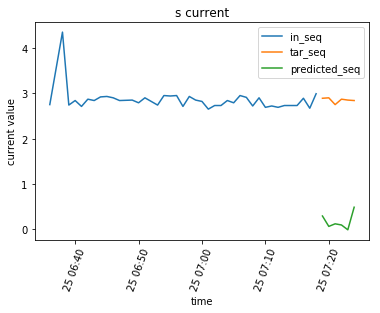

<Figure size 7200x720 with 0 Axes>

In [15]:
           '''Visualization of predicted time series'''
in_seq = raw_seq[endix:endix+w]
tar_seq = raw_seq[endix+w:endix+w+p_w]
predicted_seq = predicted_seq.reshape((p_w))
d = {'time': df_Scurr['DataSavedTime'][endix+w:endix+w+p_w], 'current': predicted_seq}
df_Scurr_pre = pd.DataFrame(data=d)
pre_seq = df_Scurr_pre['current']

plt.xticks(rotation=70)
plt.plot_date(x=df_Scurr['DataSavedTime'][endix:endix+w], y=in_seq, 
              linestyle='solid', marker='None')
plt.plot_date(x=df_Scurr['DataSavedTime'][endix+w:endix+w+p_w], y=tar_seq, 
              linestyle='solid', marker='None')
plt.plot_date(x=df_Scurr['DataSavedTime'][endix+w:endix+w+p_w], y=pre_seq, 
              linestyle='solid', marker='None')
plt.title('s current')
plt.ylabel('current value')
plt.xlabel('time')
plt.legend(['in_seq', 'tar_seq', 'predicted_seq'], loc='upper right')
axes = plt.gca()
# axes.set_xlim(df_Scurr['DataSavedTime'][endix],
#               df_Scurr['DataSavedTime'][endix+w+p_w-1])
plt.figure(figsize=(100,10))
plt.show()

In [16]:
# Shallow CNN version  
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [-5, 5, -10, 10, -15, 15, -20, 20, -25]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mean_absolute_error')
# fit model
model.fit(X, y, epochs=500, verbose=1)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=1)
print(yhat)

Epoch 1/500
5/5 [==============================] - 0s 61ms/step - loss: 17.4091
Epoch 2/500
5/5 [==============================] - 0s 425us/step - loss: 17.3047
Epoch 3/500
5/5 [==============================] - 0s 657us/step - loss: 17.2060
Epoch 4/500
5/5 [==============================] - 0s 442us/step - loss: 17.1055
Epoch 5/500
5/5 [==============================] - 0s 543us/step - loss: 17.0029
Epoch 6/500
5/5 [==============================] - 0s 436us/step - loss: 16.9068
Epoch 7/500
5/5 [==============================] - 0s 384us/step - loss: 16.8127
Epoch 8/500
5/5 [==============================] - 0s 543us/step - loss: 16.7241
Epoch 9/500
5/5 [==============================] - 0s 390us/step - loss: 16.6311
Epoch 10/500
5/5 [==============================] - 0s 754us/step - loss: 16.5434
Epoch 11/500
5/5 [==============================] - 0s 915us/step - loss: 16.4576
Epoch 12/500
5/5 [==============================] - 0s 671us/step - loss: 16.3701
Epoch 13/500
5/5 [========

In [0]:
               """Save Weights (ShallowAnT)"""
# save it to disk so we can load it back up anytime
model.save_weights('sinwave_ShallowAnT_1.h5')  